# Settings

In [20]:
USE_ALIGNZERO_GLOBAL = 0 
USE_ALIGNZERO_LOCAL = 0
USE_OFFSET = 1 
offset = 0.1
USE_BANDPASS = 1
window_size_seconds = 0.5
USE_NOTCH = 1
USE_ENVELOPE = 0
USE_ZSCORE = 0 
USE_SCALING = 1 
USE_FEATURESELECTION = 0
k = 20  # Number of top features to select
USE_TKEO = 1
USE_NORMALIZATION = 1

# USE_ALIGNZERO_GLOBAL = Substract the mean to each channel
# USE_ALIGNZERO_LOCAL 
# USE_OFFSET = Generate more windows with offset
# offset 
# USE_BANDPASS = Filter with bandpass (window by window)
# USE_ZSCORE = Filter with zscore (window by window)
# USE_SCALING = Use feature scaling

print("Settings updated")

Settings updated


# Get raw data

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import os

# --- File paths ---
train_data_path = '/Users/pooriaghavamian/Library/CloudStorage/OneDrive-KTH/Documents/PhD_Projects/Tongue_Interface/Github/tongue_emg_xr_project/data_OpenBCI/OpenBCISession_2025-06-27_14-53-13-Pooria/BrainFlow-RAW_2025-06-27_14-53-13-Pooria_1.csv'
train_annotations_path = r"/Users/pooriaghavamian/Library/CloudStorage/OneDrive-KTH/Documents/PhD_Projects/Tongue_Interface/Github/tongue_emg_xr_project/scripts/data/annotations/7_classes_annotations_27-06-hour-14-min-55.csv"

test_data_path = "/Users/pooriaghavamian/Library/CloudStorage/OneDrive-KTH/Documents/PhD_Projects/Tongue_Interface/Github/tongue_emg_xr_project/data_OpenBCI/OpenBCISession_PooriaTest_27_06_1/BrainFlow-RAW_PooriaTest_27_06_1_0.csv"
test_annotations_path = r"/Users/pooriaghavamian/Library/CloudStorage/OneDrive-KTH/Documents/PhD_Projects/Tongue_Interface/Github/tongue_emg_xr_project/scripts/data/annotations/7_classes_annotations_27-06-hour-14-min-00.csv"

# --- Load data ---
df_train = pd.read_csv(train_data_path, sep='\t', skiprows=5, engine='python')
print("Read df_train")
df_test = pd.read_csv(test_data_path, sep='\t', skiprows=5, engine='python')
print("Read df_test")

df_train.columns = [f"ch_{i}" for i in range(df_train.shape[1])]
df_test.columns = [f"ch_{i}" for i in range(df_test.shape[1])]

# Use these for windowing
combined_df = df_train
test_df = df_test

print(f"Final train data shape: {combined_df.shape}")


if USE_ALIGNZERO_GLOBAL == 1:
    channels = ["ch_1", "ch_2", "ch_3"]
    channel_means = combined_df[channels].mean()
    for ch in channels:
        combined_df[ch] = combined_df[ch] - channel_means[ch]

Read df_train
Read df_test
Final train data shape: (81726, 24)


# Create windows

## Train windows

In [22]:
import numpy as np
import os
import pandas as pd  

# --- EMG onset detection function ---
def detect_emg_onset(signal, fs=250, pre_samples=20, threshold_factor=3):
    """
    Detects the onset of EMG activity in a 1D signal.
    Returns: onset index (relative to signal start)
    """
    if len(signal) < pre_samples + 1:
        return 0
    baseline = np.mean(np.abs(signal[:pre_samples]))
    std = np.std(np.abs(signal[:pre_samples]))
    threshold = baseline + threshold_factor * std
    for i in range(pre_samples, len(signal)):
        if np.abs(signal[i]) > threshold:
            return i
    return 0  # fallback: no onset found

# Class labels
windowed_data = {'l': [], 'lf': [], 'f': [], 'rf': [], 'r': [], 's': [], 'n': []}

# ----------- Windows from 7 classes recordings

# Read train and test annotations separately
annotations_train = pd.read_csv(train_annotations_path, header=0, names=['class', 'timestamp'])
annotations_train['timestamp'] = pd.to_numeric(annotations_train['timestamp'], errors='coerce')

annotations_test = pd.read_csv(test_annotations_path, header=0, names=['class', 'timestamp'])
annotations_test['timestamp'] = pd.to_numeric(annotations_test['timestamp'], errors='coerce')

# Use only train annotations for training windows
annotations = annotations_train

windowed_data_7_classes = {'l': [], 'k': [], 'r': [], 'e': [], 'f': [], 'n': [], 's': [], 'c': []}

offsets = [0]
if USE_OFFSET == 1:
    offsets = [0, -offset, offset]

search_radius = 0.3  # seconds before and after annotation to search for onset

for idx, row in annotations.iterrows():
    label = row['class']
    base_time = row['timestamp']
    
    for shift in offsets:
        if label == 'n':
            # For idle, use annotation timestamp directly
            start_time = base_time + shift
        else:
            # For active classes, search for onset
            search_start = base_time + shift - search_radius
            search_end = base_time + shift + search_radius
            idxs = (combined_df['ch_22'] >= search_start) & (combined_df['ch_22'] < search_end)
            if not any(idxs):
                print(f"No data for window starting at {search_start:.3f} (label={label}, offset={shift:+.1f}s)")
                continue

            emg_segment = combined_df['ch_1'][idxs].to_numpy()
            onset_idx = detect_emg_onset(emg_segment, fs=250)
            if onset_idx > 0:
                onset_time = combined_df['ch_22'][idxs].iloc[onset_idx]
            else:
                onset_time = base_time + shift
            start_time = onset_time

        end_time = start_time + window_size_seconds
        idxs_window = (combined_df['ch_22'] >= start_time) & (combined_df['ch_22'] < end_time)
        if not any(idxs_window):
            print(f"No data for window after onset at {start_time:.3f} (label={label}, offset={shift:+.1f}s)")
            continue

        window_data = {}
        for ch in ['ch_1', 'ch_2', 'ch_3']:
            window_data[ch] = combined_df[ch][idxs_window]

        windowed_data_7_classes[label].append({
            'ch_1': window_data.get('ch_1', []),
            'ch_2': window_data.get('ch_2', []),
            'ch_3': window_data.get('ch_3', []),
        })

print("Acquired windows for 6 classes")

print(f"Label l:")
for i, window_dict in enumerate(windowed_data_7_classes['l'][:10]):
    size = len(window_dict['ch_1'])
    print(f"  Window {i+1}: size = {size} samples")

# ----------- Combine windows

windowed_data_7_map = {
    'l': 'l',
    'k': 'lf',
    'r': 'r',
    'e': 'rf',
    'f': 'f',
    'n': 'n',
    's': 's'
}

class_map = {
    'left': 'l',
    'left_front': 'lf',
    'front': 'f',
    'right_front': 'rf',
    'right': 'r',
    'swallow': 's',
    'none': 'n'
}

for src_label, tgt_label in windowed_data_7_map.items():
    for window_dict in windowed_data_7_classes[src_label]:
        ch1 = window_dict['ch_1'].to_numpy() if hasattr(window_dict['ch_1'], 'to_numpy') else np.array(window_dict['ch_1'])
        ch2 = window_dict['ch_2'].to_numpy() if hasattr(window_dict['ch_2'], 'to_numpy') else np.array(window_dict['ch_2'])
        ch3 = window_dict['ch_3'].to_numpy() if hasattr(window_dict['ch_3'], 'to_numpy') else np.array(window_dict['ch_3'])
        arr = np.column_stack([ch1, ch2, ch3])
        windowed_data[tgt_label].append(arr)

print("---- Train windows")
for long_label, short_label in class_map.items():
    print(f"Class '{short_label}': {len(windowed_data[short_label])} windows.")



Acquired windows for 6 classes
Label l:
  Window 1: size = 125 samples
  Window 2: size = 125 samples
  Window 3: size = 125 samples
  Window 4: size = 125 samples
  Window 5: size = 125 samples
  Window 6: size = 125 samples
  Window 7: size = 125 samples
  Window 8: size = 125 samples
  Window 9: size = 125 samples
  Window 10: size = 126 samples
---- Train windows
Class 'l': 60 windows.
Class 'lf': 60 windows.
Class 'f': 63 windows.
Class 'rf': 60 windows.
Class 'r': 60 windows.
Class 's': 57 windows.
Class 'n': 60 windows.


## Test windows

In [23]:
import numpy as np
import os
import pandas as pd  

# Class labels
windowed_data_test = {'l': [], 'lf': [], 'f': [], 'rf': [], 'r': [], 's': [], 'n': []} 

# ----------- Windows from 7 classes recordings
annotations_test['timestamp'] = pd.to_numeric(annotations_test['timestamp'], errors='coerce')

windowed_data_7_classes_test = {'l': [], 'k': [], 'r': [], 'e': [], 'f': [], 'n': [], 's': [], 'c': []}

offsets = [0]
if USE_OFFSET == 1:
    offsets = [0, -offset, offset]

for idx, row in annotations_test.iterrows():
    label = row['class']
    base_time = row['timestamp']
    
    for shift in offsets:
        start_time = base_time + shift
        end_time = start_time + window_size_seconds

        idxs = (test_df['ch_22'] >= start_time) & (test_df['ch_22'] < end_time)

        if not any(idxs):
            print(f"No data for window starting at {start_time:.3f} (label={label}, offset={shift:+.1f}s)")
            continue

        window_data = {}
        for ch in ['ch_1', 'ch_2', 'ch_3']:
            window_data[ch] = test_df[ch][idxs]

        windowed_data_7_classes_test[label].append({
            'ch_1': window_data.get('ch_1', []),
            'ch_2': window_data.get('ch_2', []),
            'ch_3': window_data.get('ch_3', []),
        })

print("Acquired windows for 6 classes")

print(f"Label l:")
for i, window_dict in enumerate(windowed_data_7_classes_test['l'][:10]):
    # Get the length of ch_1 series or list
    size = len(window_dict['ch_1'])
    print(f"  Window {i+1}: size = {size} samples")

# ----------- Combine windows

for src_label, tgt_label in windowed_data_7_map.items():
    for window_dict in windowed_data_7_classes_test[src_label]:
        # Convert dict of series to (N, 3) array
        ch1 = window_dict['ch_1'].to_numpy() if hasattr(window_dict['ch_1'], 'to_numpy') else np.array(window_dict['ch_1'])
        ch2 = window_dict['ch_2'].to_numpy() if hasattr(window_dict['ch_2'], 'to_numpy') else np.array(window_dict['ch_2'])
        ch3 = window_dict['ch_3'].to_numpy() if hasattr(window_dict['ch_3'], 'to_numpy') else np.array(window_dict['ch_3'])

        # Stack as (N, 3) array
        arr = np.column_stack([ch1, ch2, ch3])
        
        windowed_data_test[tgt_label].append(arr)


print("---- Test windows")
for long_label, short_label in class_map.items():
    print(f"Class '{short_label}': {len(windowed_data_test[short_label])} windows.")





Acquired windows for 6 classes
Label l:
  Window 1: size = 125 samples
  Window 2: size = 125 samples
  Window 3: size = 125 samples
  Window 4: size = 125 samples
  Window 5: size = 125 samples
  Window 6: size = 125 samples
  Window 7: size = 125 samples
  Window 8: size = 125 samples
  Window 9: size = 125 samples
  Window 10: size = 125 samples
---- Test windows
Class 'l': 78 windows.
Class 'lf': 90 windows.
Class 'f': 75 windows.
Class 'rf': 63 windows.
Class 'r': 63 windows.
Class 's': 93 windows.
Class 'n': 24 windows.


## Plot raw windows (only Train)

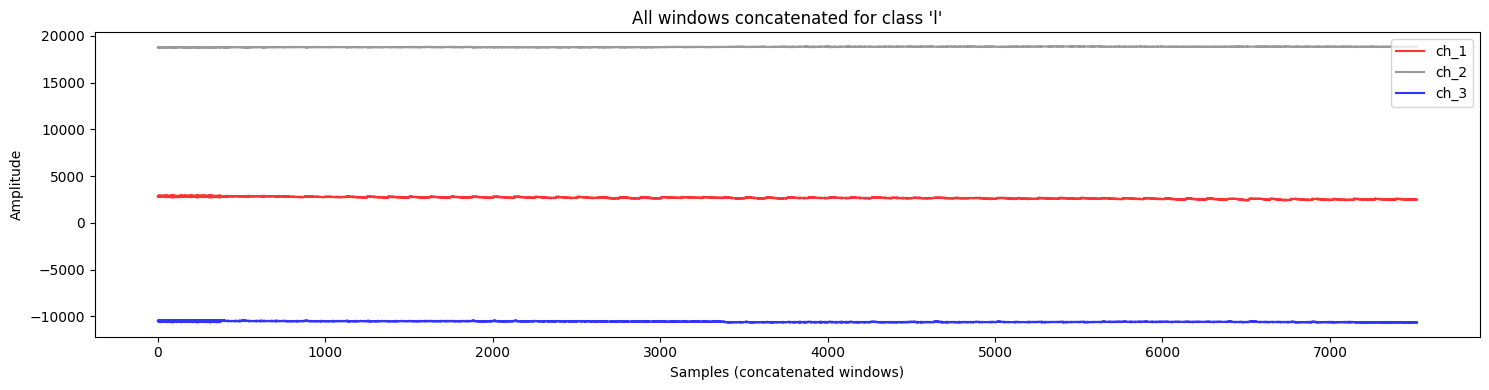

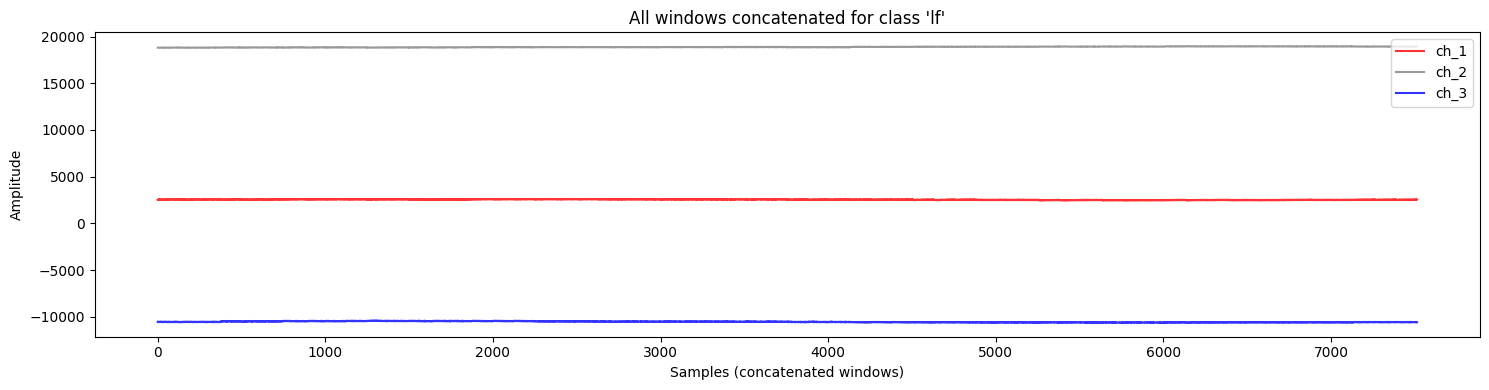

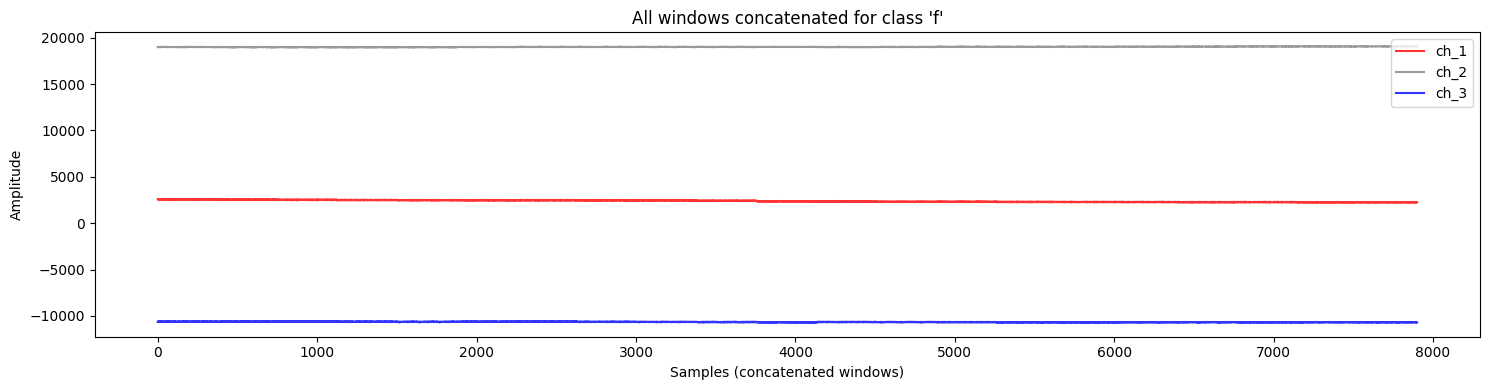

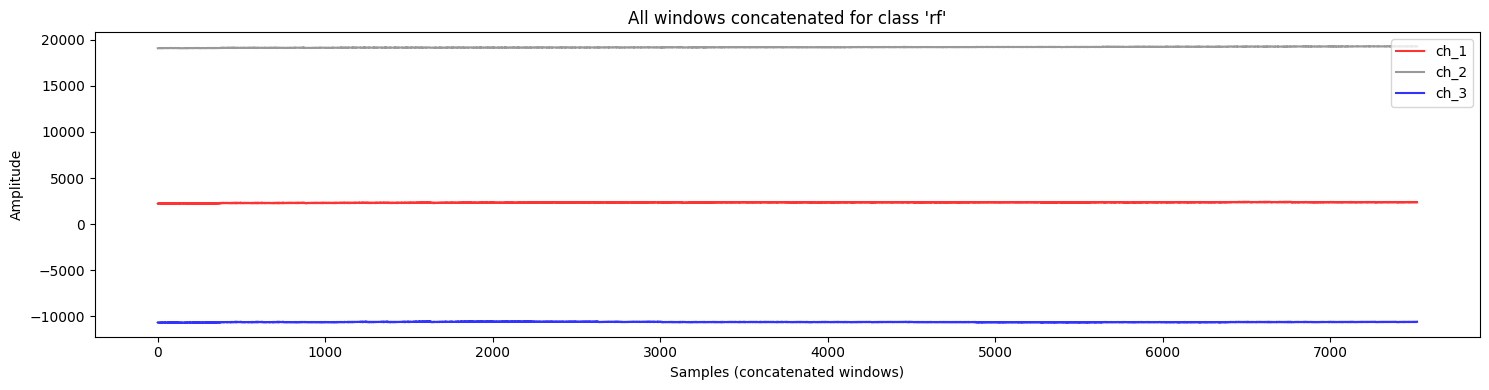

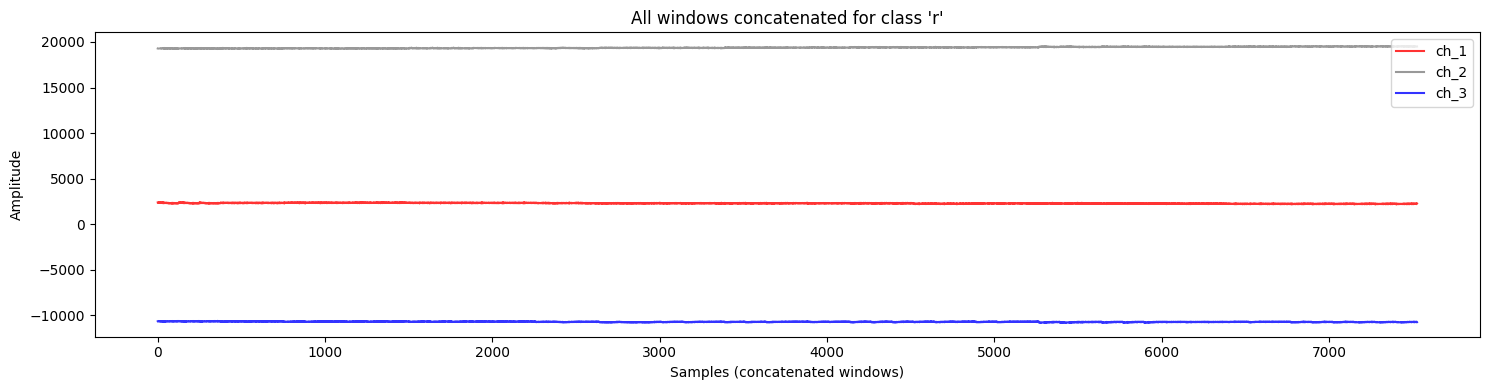

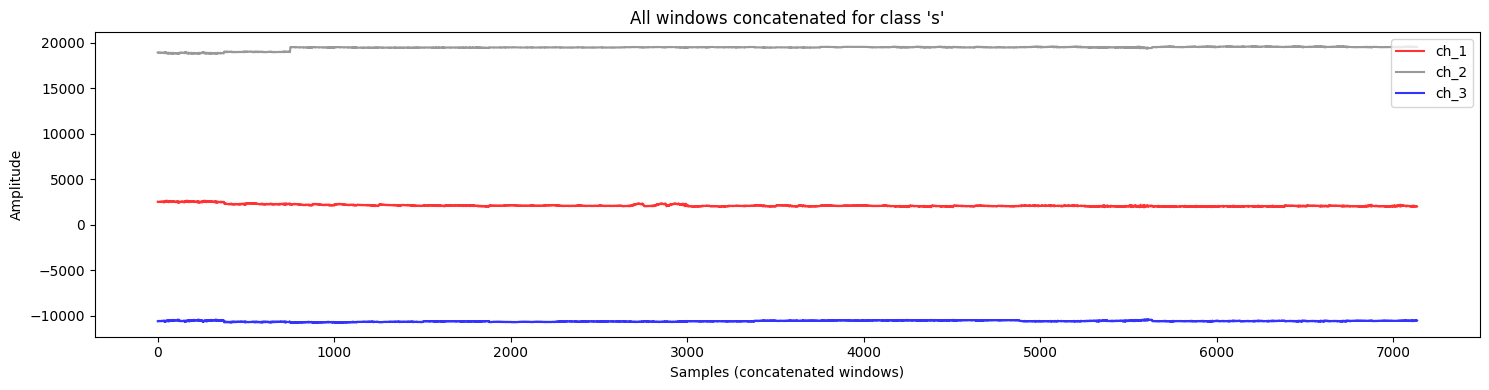

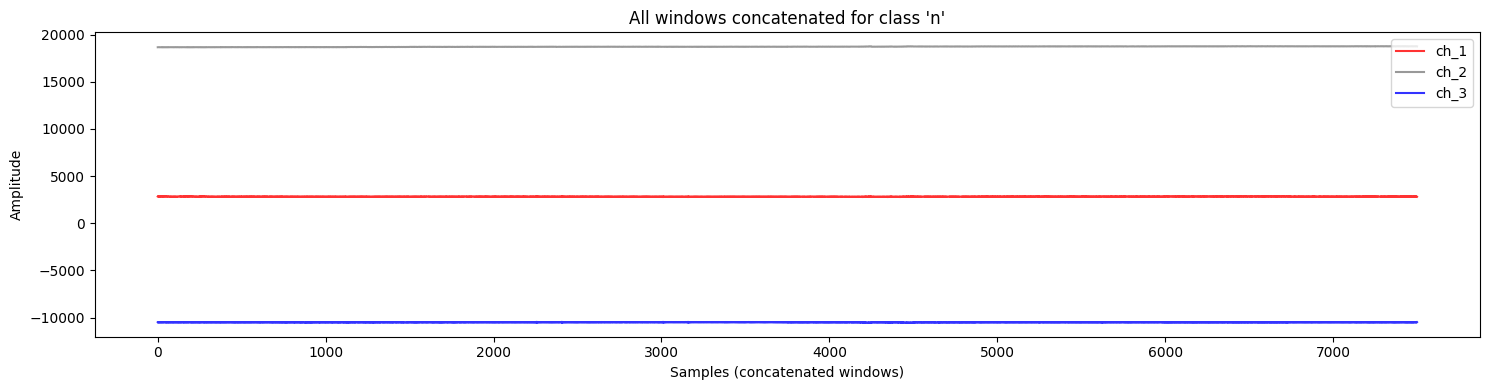

In [24]:
import matplotlib.pyplot as plt
import numpy as np

# Colors for channels
channel_colors = {'ch_1': 'red', 'ch_2': 'gray', 'ch_3': 'blue'}
channels = ['ch_1', 'ch_2', 'ch_3']

for class_label, windows in windowed_data.items():
    if not windows:
        print(f"No windows for class '{class_label}', skipping plot.")
        continue
    
    # Concatenate all windows along time axis (axis=0)
    # Each window shape: (samples, 3 channels)
    concatenated = np.vstack(windows)  # shape: (num_windows * samples, 3)
    
    plt.figure(figsize=(15, 4))
    
    for i, ch in enumerate(channels):
        plt.plot(concatenated[:, i], color=channel_colors[ch], label=ch, alpha=0.8)
    
    plt.title(f"All windows concatenated for class '{class_label}'")
    plt.xlabel("Samples (concatenated windows)")
    plt.ylabel("Amplitude")
    plt.legend()
    plt.tight_layout()
    plt.show()


## Filter windows

In [25]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import butter, filtfilt, iirnotch

def bandpass_filter(data, lowcut=5.0, highcut=50.0, fs=250.0, order=4):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, data)

def high_pass_filter(signal, cutoff=0.1, fs=250, order=4):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='high', analog=False)
    filtered_signal = filtfilt(b, a, signal)
    return filtered_signal

def notch_filter(signal, freq=50.0, fs=250, quality=30):
    nyquist = 0.5 * fs
    norm_freq = freq / nyquist
    b, a = iirnotch(norm_freq, quality)
    filtered_signal = filtfilt(b, a, signal)
    return filtered_signal

def compute_envelope(signal, fs=250, cutoff=5.0):
    rectified = np.abs(signal)
    b, a = butter(4, cutoff / (0.5 * fs), btype='low')
    envelope = filtfilt(b, a, rectified)
    return envelope

def tkeo(signal):
    # Teager-Kaiser Energy Operator 
    output = np.zeros_like(signal)
    for i in range(1, len(signal) - 1):
        output[i] = signal[i]**2 - signal[i - 1] * signal[i + 1]  
    return output

def filter_dataset(dataset, dataset_name=""):
    filtered_dataset = {}

    for class_label, windows in dataset.items():
        if not windows:
            print(f"No windows for class '{class_label}' in {dataset_name}, skipping filter.")
            continue
        
        fwindows = []
        for window in windows:
            if window.shape[0] <= 30:
                print(f"Skipping short window of length {window.shape[0]} for class '{class_label}'")
                continue
            one_window = window.copy()
            for i in range(window.shape[1]): 
                if i in [0, 1, 2]:  # Filter ONLY CHANNELS 1, 2 AND 3

                    if USE_NOTCH == 1:
                        one_window[:, i] = notch_filter(one_window[:, i])
                        
                    if USE_BANDPASS == 1:
                        one_window[:, i] = bandpass_filter(one_window[:, i])

                    if USE_TKEO == 1:
                        one_window[:,i] = tkeo(one_window[:,i])

                    if USE_ENVELOPE == 1:
                        one_window[:, i] = compute_envelope(one_window[:, i])

                    if USE_ZSCORE == 1:
                        mean = one_window[:, i].mean()
                        std = one_window[:, i].std()
                        if std == 0:
                            std = 1
                        one_window[:, i] = (one_window[:, i] - mean) / std
                        
                    if USE_ALIGNZERO_LOCAL == 1:
                        mean = one_window[:, i].mean()
                        one_window[:, i] = one_window[:, i] - mean
                        
            fwindows.append(one_window)

        filtered_dataset[class_label] = fwindows

    print(f"Filtering completed for {dataset_name}")
    return filtered_dataset

# Filter train and test datasets
filtered = filter_dataset(windowed_data, "train set")
filtered_test = filter_dataset(windowed_data_test, "test set")


Filtering completed for train set
Filtering completed for test set


## Plot filtered windows (only Train)

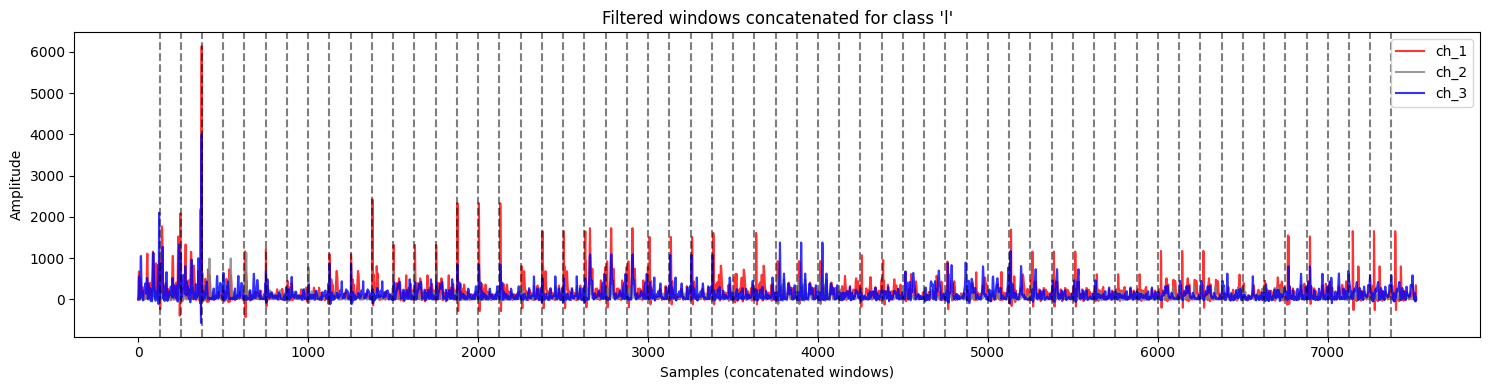

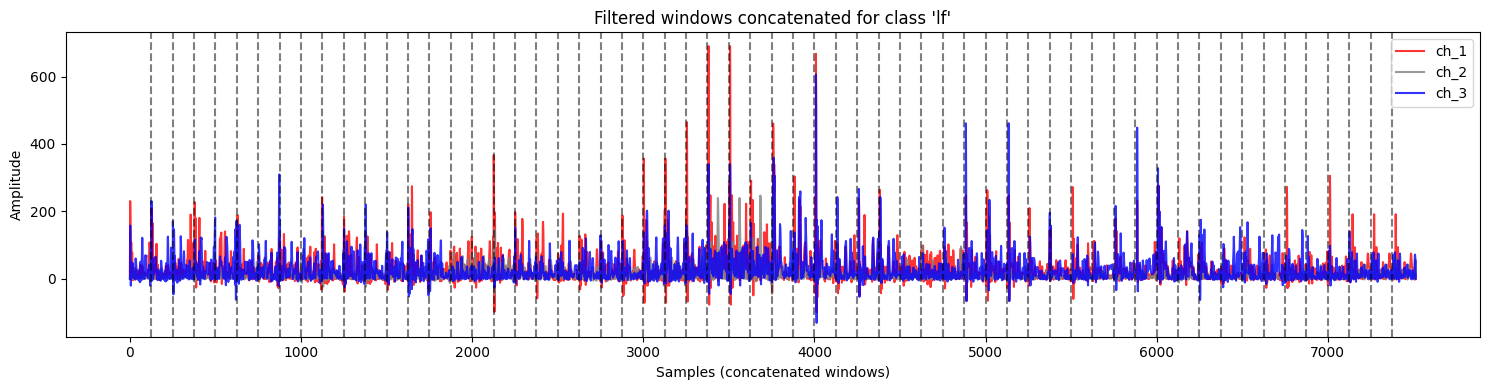

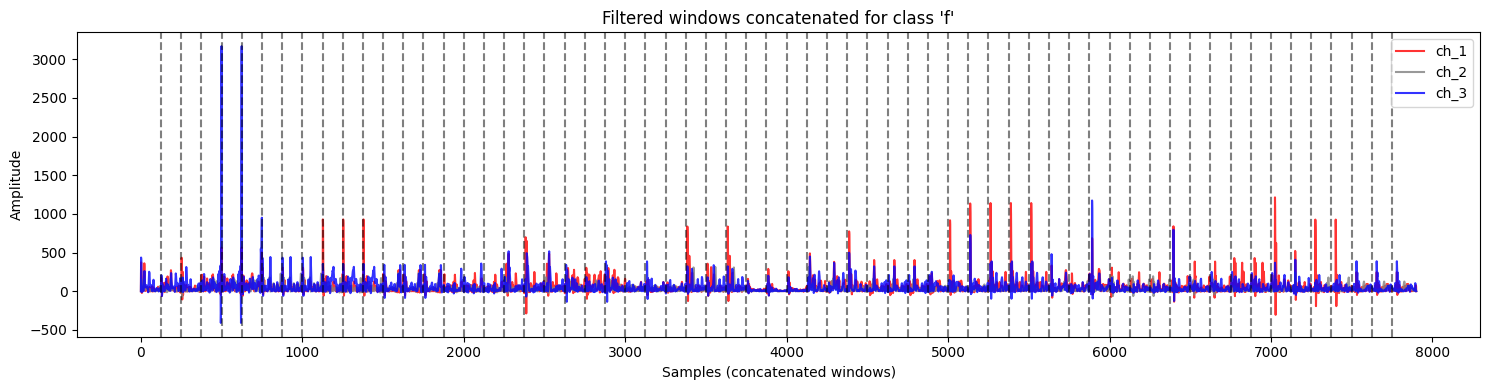

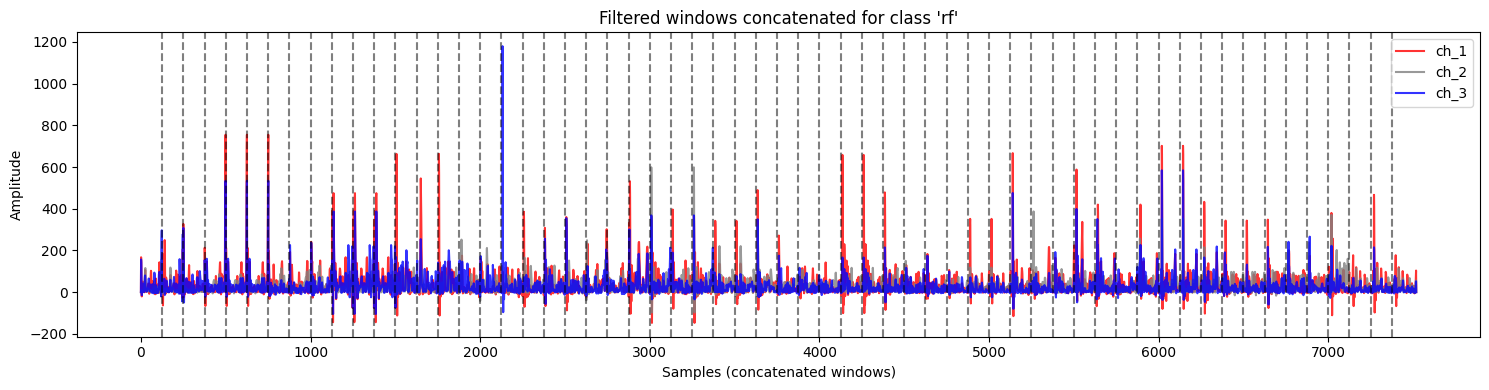

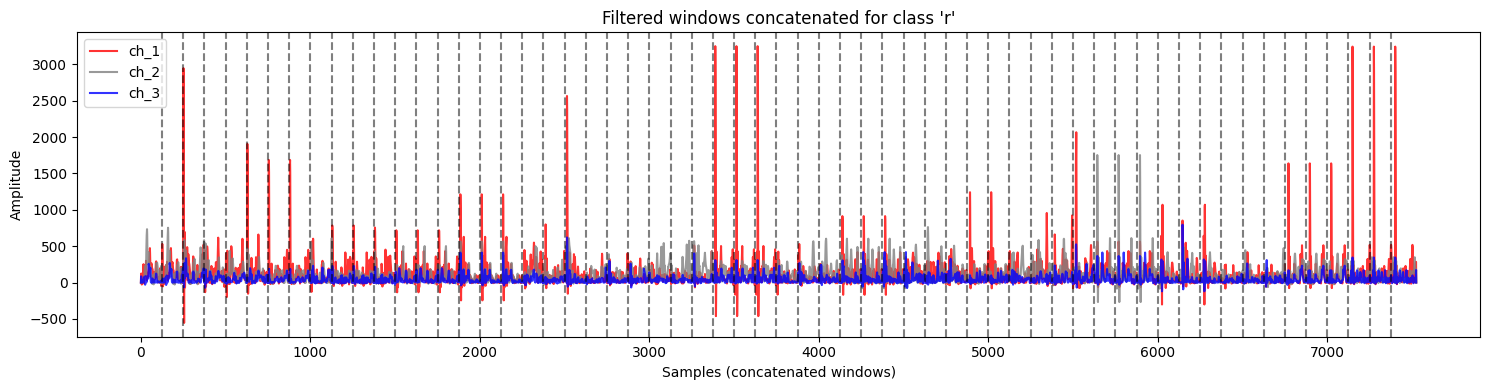

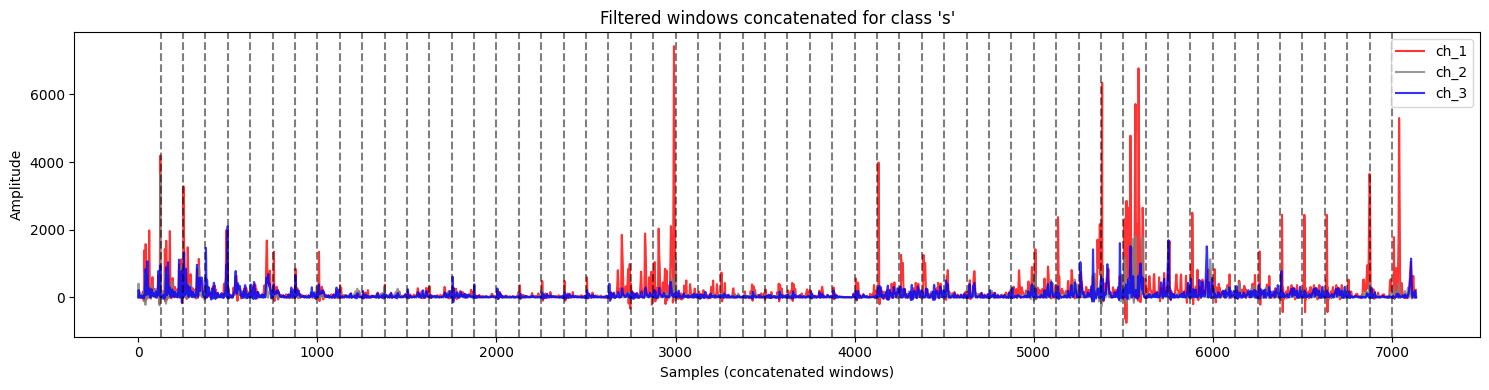

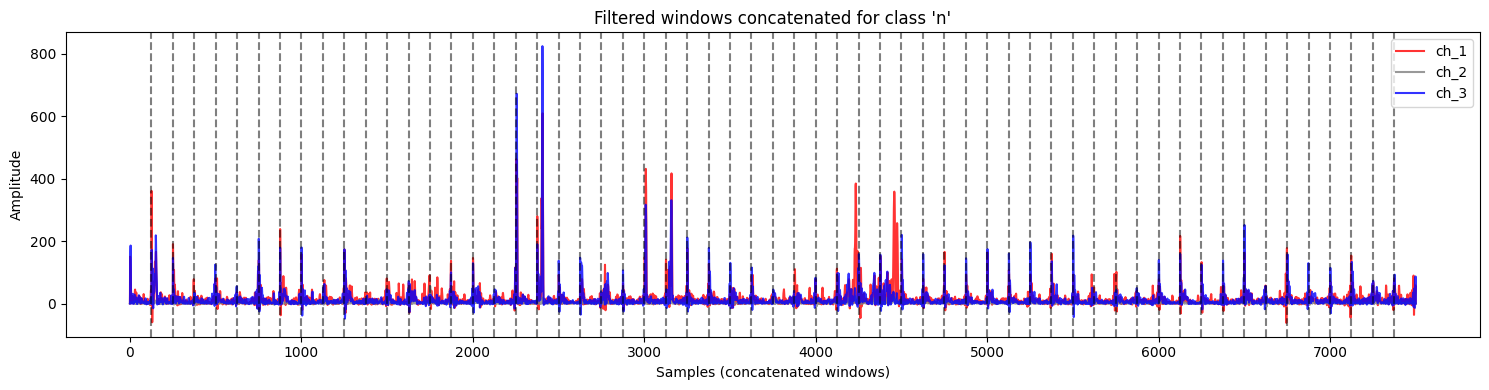

In [26]:
# Colors for channels
channel_colors = {'ch_1': 'red', 'ch_2': 'gray', 'ch_3': 'blue'}
channels = ['ch_1', 'ch_2', 'ch_3']

# For each label...
for class_label, windows in filtered.items():
    if not windows:
        continue

    #... concatenate
    concatenated = np.vstack(windows)
    plt.figure(figsize=(15, 4))

    # Plot each channel
    for i, ch in enumerate(channels):
        plt.plot(concatenated[:, i], color=channel_colors[ch], label=ch, alpha=0.8)
    
    # Add vertical lines between windows
    window_length = windows[0].shape[0]  # samples per window
    num_windows = len(windows)
    for w in range(1, num_windows):
        plt.axvline(x=w * window_length, color='black', linestyle='--', alpha=0.5)
    
    plt.title(f"Filtered windows concatenated for class '{class_label}'")
    plt.xlabel("Samples (concatenated windows)")
    plt.ylabel("Amplitude")
    plt.legend()
    plt.tight_layout()
    plt.show()


## Plot filtered windows (only Test)

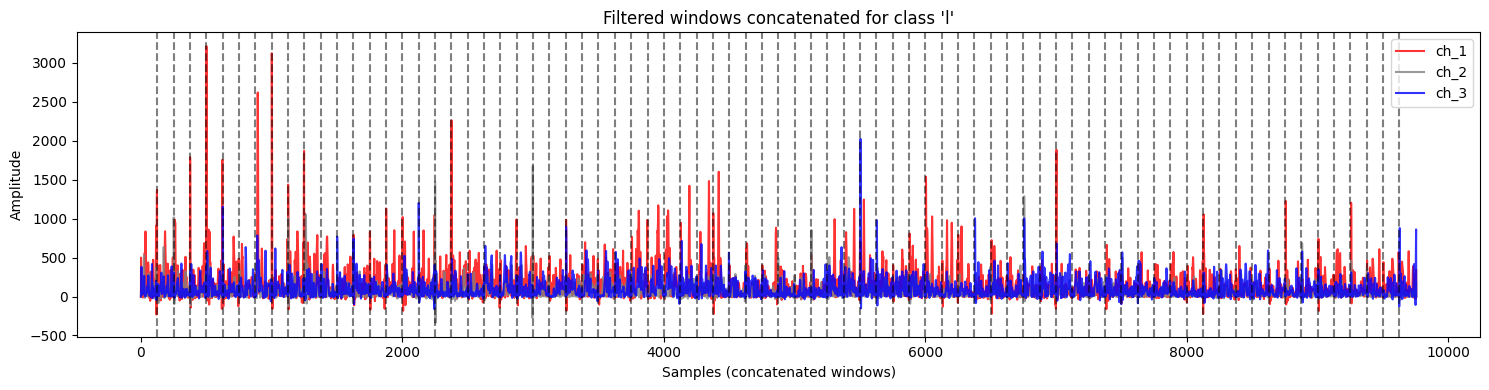

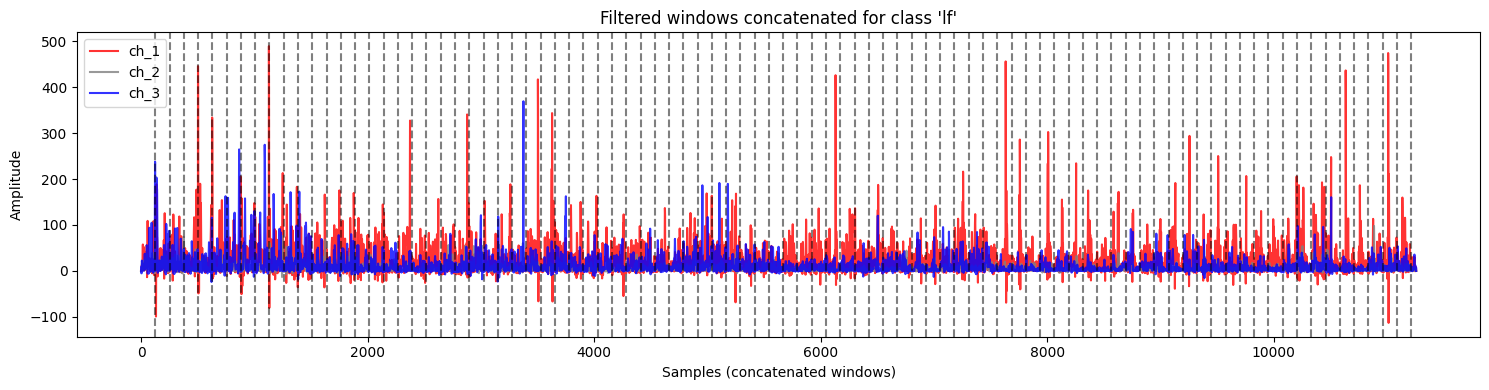

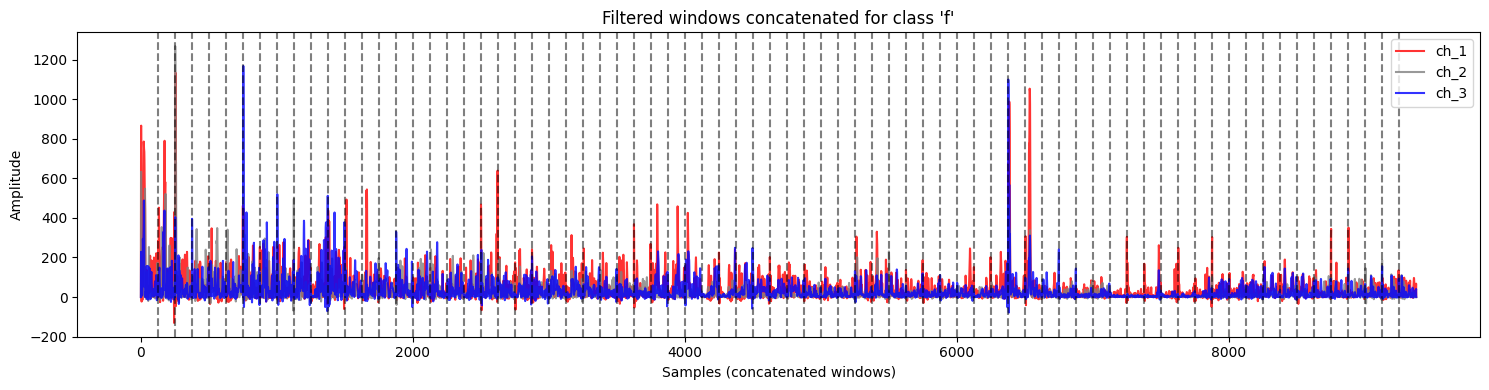

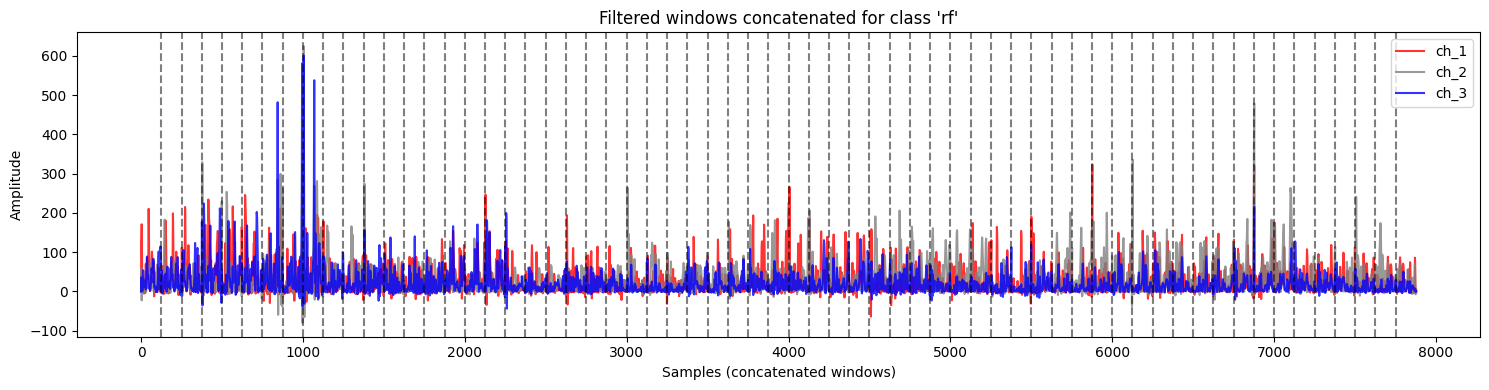

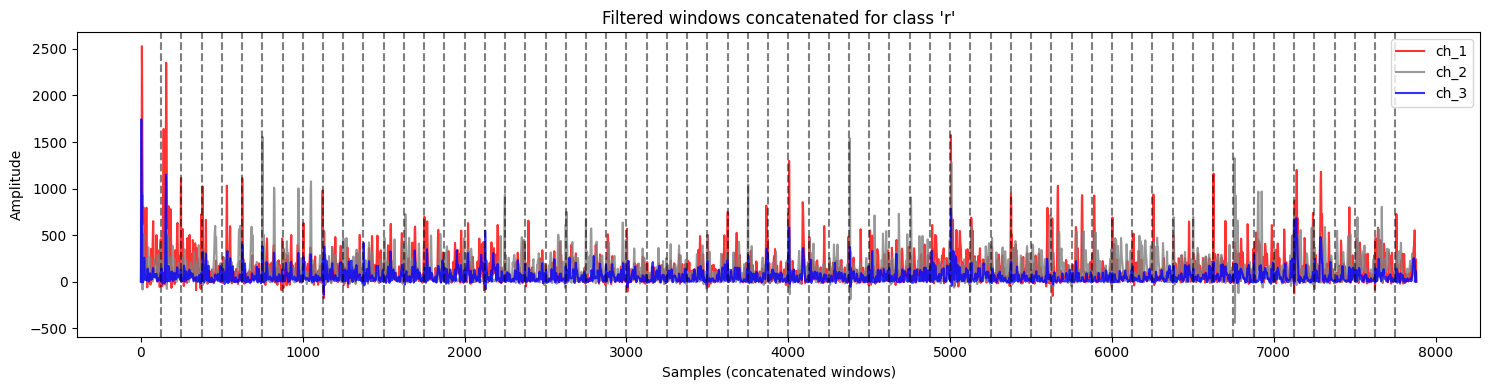

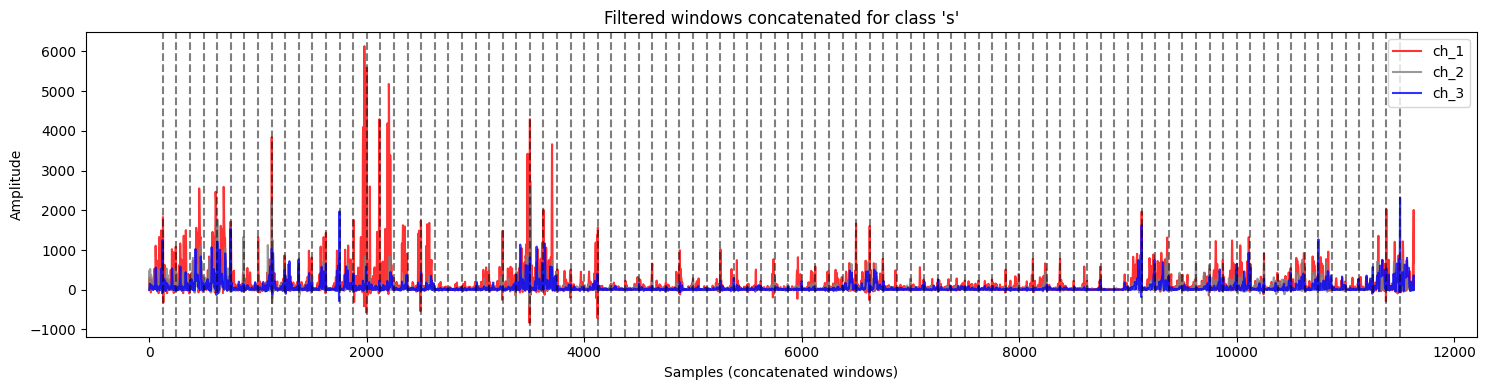

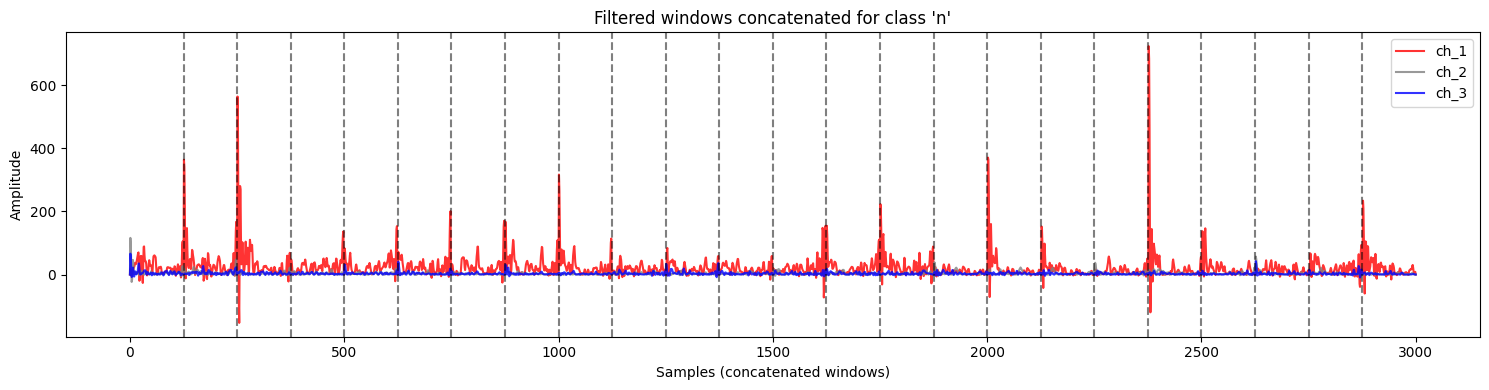

In [27]:
# Colors for channels
channel_colors = {'ch_1': 'red', 'ch_2': 'gray', 'ch_3': 'blue'}
channels = ['ch_1', 'ch_2', 'ch_3']

# For each label...
for class_label, windows in filtered_test.items():
    if not windows:
        continue

    #... concatenate
    concatenated = np.vstack(windows)
    plt.figure(figsize=(15, 4))

    # Plot each channel
    for i, ch in enumerate(channels):
        plt.plot(concatenated[:, i], color=channel_colors[ch], label=ch, alpha=0.8)
    
    # Add vertical lines between windows
    window_length = windows[0].shape[0]  # samples per window
    num_windows = len(windows)
    for w in range(1, num_windows):
        plt.axvline(x=w * window_length, color='black', linestyle='--', alpha=0.5)
    
    plt.title(f"Filtered windows concatenated for class '{class_label}'")
    plt.xlabel("Samples (concatenated windows)")
    plt.ylabel("Amplitude")
    plt.legend()
    plt.tight_layout()
    plt.show()


## Normalisation (Max value, no swallow)

In [28]:

def normalization_max_val(signal, dataset_name, channel_index=None):
    # This function normalizes the window for specified channel, according to the 
    # maximum absolute value, which is stored as a list. 
    
    if dataset_name == "train set":
        max_vals = mav_3ch
    elif dataset_name == "test set":
        max_vals = mav_3ch_test
    else:
        raise ValueError("Unknown dataset name provided for normalization.")
    
    if channel_index is None:
        raise ValueError("Channel index must be provided for normalization.")
    
    max_val = max_vals[channel_index]
    return signal / max_val if max_val != 0 else signal

def filter_dataset_max_val(dataset, dataset_name=""):
    filtered_dataset = {}

    for class_label, windows in dataset.items():
        if not windows:
            print(f"No windows for class '{class_label}' in {dataset_name}, skipping filter.")
            continue
        
        fwindows = []
        for window in windows:
            if window.shape[0] <= 30:
                print(f"Skipping short window of length {window.shape[0]} for class '{class_label}'")
                continue
            one_window = window.copy()
            for i in range(window.shape[1]): 
                if i in [0, 1, 2]:  # Filter each channel separatedly

                    if USE_NORMALIZATION == 1:
                        one_window[:, i] = normalization_max_val(one_window[:, i], dataset_name, channel_index=i)
                        
            fwindows.append(one_window)

        filtered_dataset[class_label] = fwindows

    print(f"Filtering completed for {dataset_name}")
    return filtered_dataset

def maximum_absolute_value(windowed_data):
    max_vals = np.zeros(3)  # For ch_1, ch_2, ch_3

    for class_label, windows in windowed_data.items():
        if class_label == 's':
            continue  # Skip class 's'
        for window in windows:
            abs_window = np.abs(window)  # Absolute value of each sample
            max_vals = np.maximum(max_vals, abs_window.max(axis=0))  # Compare max per channel

    return max_vals.tolist()  # Return as list for readability


mav_3ch = maximum_absolute_value(filtered)
mav_3ch_test = maximum_absolute_value(filtered_test)

print("Train - Maximum absolute values per channel [ch_1, ch_2, ch_3]:", mav_3ch)
print("Test - Maximum absolute values per channel [ch_1, ch_2, ch_3]:", mav_3ch_test)

# Filter train and test datasets
filtered = filter_dataset_max_val(filtered, "train set")
filtered_test = filter_dataset_max_val(filtered_test, "test set")


Train - Maximum absolute values per channel [ch_1, ch_2, ch_3]: [6139.545333387723, 1753.0171503916195, 4000.5413412697317]
Test - Maximum absolute values per channel [ch_1, ch_2, ch_3]: [3214.0500465681353, 1673.1747198382277, 2023.892550729652]
Filtering completed for train set
Filtering completed for test set


# Feature extraction

In [29]:
import numpy as np
import pandas as pd

# -------------- Feature functions 
def rms(signal):
    return np.sqrt(np.mean(signal**2))

def zero_crossings(signal):
    signs = np.signbit(signal)
    return np.sum(signs[1:] != signs[:-1])

def waveform_length(signal):
    return np.sum(np.abs(np.diff(signal)))

def mav(signal):
    return np.mean(np.abs(signal))

def iav(signal):
    return np.sum(np.abs(signal))

def rms_signed_difference(signal):
    mean_val = np.mean(signal)
    diff = signal - mean_val
    return np.sqrt(np.mean(diff**2))

def mean_frequency(signal, fs=250):
    # Compute FFT
    freqs = np.fft.rfftfreq(len(signal), d=1/fs)
    fft_vals = np.abs(np.fft.rfft(signal))
    power = fft_vals ** 2
    if np.sum(power) == 0:
        return 0
    mf = np.sum(freqs * power) / np.sum(power)
    return mf

# -------------------

class_labels = ['l', 'lf', 'f', 'rf', 'r', 's', 'n']
channels = ['ch_1', 'ch_2', 'ch_3']
feature_names = ['RMS', 'RMS_SD', 'ZC', 'WL', 'MAV', 'STD', 'VAR', 'IAV', 'MF']

def extract_features(filtered_data):
    features = []
    labels = []

    for label in class_labels:
        for window in filtered_data.get(label, []):
            feats = []
            for ch_idx in range(len(channels)):
                ch_signal = window[:, ch_idx]
                feats.append(rms(ch_signal))
                feats.append(rms_signed_difference(ch_signal))
                feats.append(zero_crossings(ch_signal))
                feats.append(waveform_length(ch_signal))
                feats.append(mav(ch_signal))
                feats.append(np.std(ch_signal))
                feats.append(np.var(ch_signal))
                feats.append(iav(ch_signal))
                feats.append(mean_frequency(ch_signal))
                
            features.append(feats)
            labels.append(label)

    cols = []
    for ch in channels:
        for feat_name in feature_names:
            cols.append(f"{ch}_{feat_name}")

    X = pd.DataFrame(features, columns=cols)
    y = pd.Series(labels, name='label')
    return X, y

# Extract features for train and test
X, y = extract_features(filtered)
Xt, yt = extract_features(filtered_test)

print("--- Train:")
print(X.head())
print(y.head())

print("\n--- Test:")
print(Xt.head())
print(yt.head())


--- Train:
   ch_1_RMS  ch_1_RMS_SD  ch_1_ZC   ch_1_WL  ch_1_MAV  ch_1_STD  ch_1_VAR  \
0  0.073018     0.049398        2  1.833095  0.053826  0.049398  0.002440   
1  0.105963     0.082214        6  3.266701  0.068768  0.082214  0.006759   
2  0.155052     0.134314       10  4.810100  0.078869  0.134314  0.018040   
3  0.032526     0.026723       14  0.984297  0.019379  0.026723  0.000714   
4  0.032526     0.026723       14  0.984297  0.019379  0.026723  0.000714   

   ch_1_IAV    ch_1_MF  ch_2_RMS  ...   ch_2_MF  ch_3_RMS  ch_3_RMS_SD  \
0  6.728238   4.172280  0.057448  ...  7.212791  0.117680     0.086765   
1  8.595963   8.234717  0.051697  ...  6.287961  0.117439     0.083789   
2  9.858687  17.438443  0.054880  ...  5.879992  0.156677     0.131814   
3  2.422351   8.272682  0.136833  ...  4.305499  0.052419     0.038079   
4  2.422351   8.272682  0.136833  ...  4.305499  0.052419     0.038079   

   ch_3_ZC   ch_3_WL  ch_3_MAV  ch_3_STD  ch_3_VAR   ch_3_IAV    ch_3_MF  
0     

# Classification

## Random Forest Tree

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best parameters found: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 100}
Random Forest Test Accuracy: 0.881
              precision    recall  f1-score   support

           l       0.86      0.95      0.90        19
          lf       0.89      0.89      0.89        18
           f       0.89      0.94      0.92        18
          rf       0.94      0.94      0.94        18
           r       0.89      0.94      0.92        18
           s       0.94      0.89      0.91        18
           n       0.71      0.59      0.65        17

    accuracy                           0.88       126
   macro avg       0.88      0.88      0.88       126
weighted avg       0.88      0.88      0.88       126



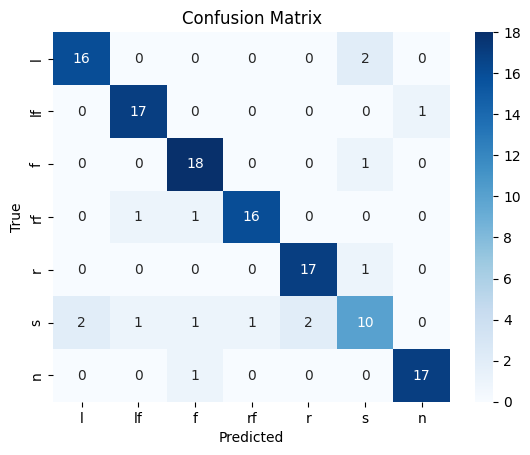

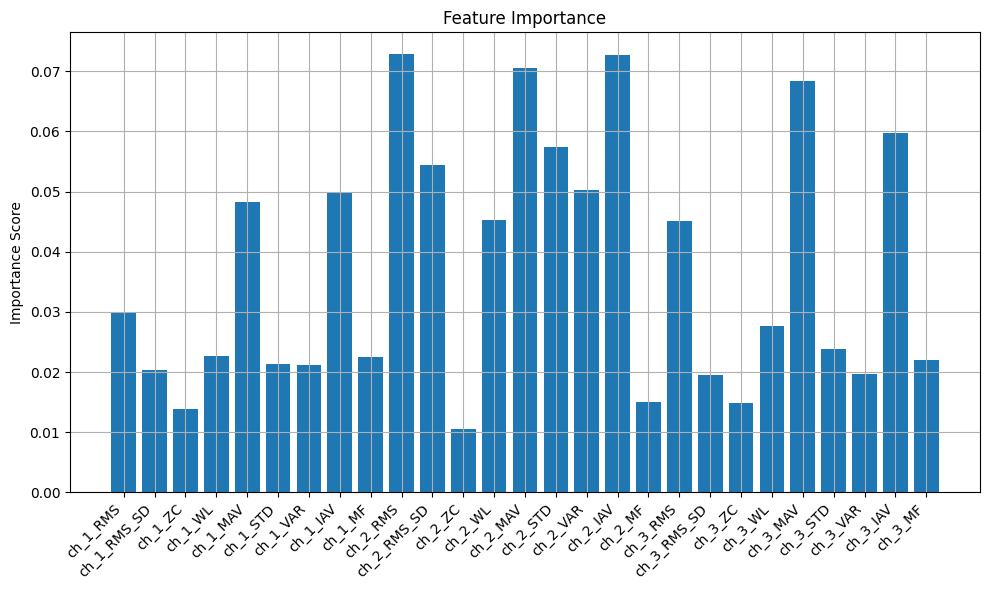

['6_classes_scaler_rf_cont_18_06_normalised.pkl']

In [30]:
# ------------------------------- RANDOM FOREST TREE

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
import joblib

# 1. Split data 
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# 2. Scale features
scaler_RF = StandardScaler()
X_train_scaled_array = scaler_RF.fit_transform(X_train)
X_test_scaled_array = scaler_RF.transform(X_test)

# Wrap back into DataFrames with feature names
X_train_scaled = pd.DataFrame(X_train_scaled_array, columns=X.columns)
X_test_scaled = pd.DataFrame(X_test_scaled_array, columns=X.columns)

# 3. Train with GridSearchCV & 4. Predict
param_grid = {
    'n_estimators': [100, 300, 500],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}

grid_search = GridSearchCV(
    RandomForestClassifier(class_weight='balanced', random_state=42),
    param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

if USE_SCALING == 1:
    grid_search.fit(X_train_scaled, y_train)
    X_eval = X_test_scaled
else:
    grid_search.fit(X_train, y_train)
    X_eval = X_test

print("Best parameters found:", grid_search.best_params_)

clf_RF = grid_search.best_estimator_
y_pred = clf_RF.predict(X_eval)

# 5. Evaluate
acc = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred, labels=['l', 'lf', 'f', 'rf', 'r', 's', 'n'])

print(f"Random Forest Test Accuracy: {acc:.3f}")
print(classification_report(y_test, y_pred, target_names=['l', 'lf', 'f', 'rf', 'r', 's', 'n']))

# 6. Plot confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['l', 'lf', 'f', 'rf', 'r', 's', 'n'],
            yticklabels=['l', 'lf', 'f', 'rf', 'r', 's', 'n'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# 7. Plot feature importance
importances = clf_RF.feature_importances_
feature_names = X.columns if hasattr(X, 'columns') else [f'feat{i}' for i in range(X.shape[1])]

plt.figure(figsize=(10,6))
plt.bar(feature_names, importances)
plt.title("Feature Importance")
plt.ylabel("Importance Score")
plt.xticks(rotation=45, ha='right')
plt.grid(True)
plt.tight_layout()
plt.show()

# 8. Save model and scaler
joblib.dump(clf_RF, "6_classes_rf_cont_18_06_normalised.pkl")
joblib.dump(scaler_RF, "6_classes_scaler_rf_cont_18_06_normalised.pkl")


## Random Forest Tree with Feature Selection

Random Forest Test Accuracy: 0.889


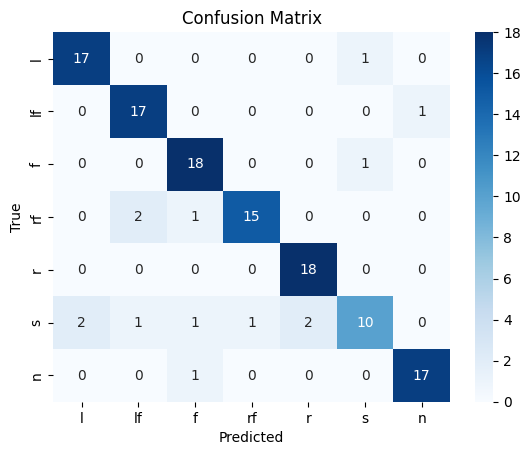

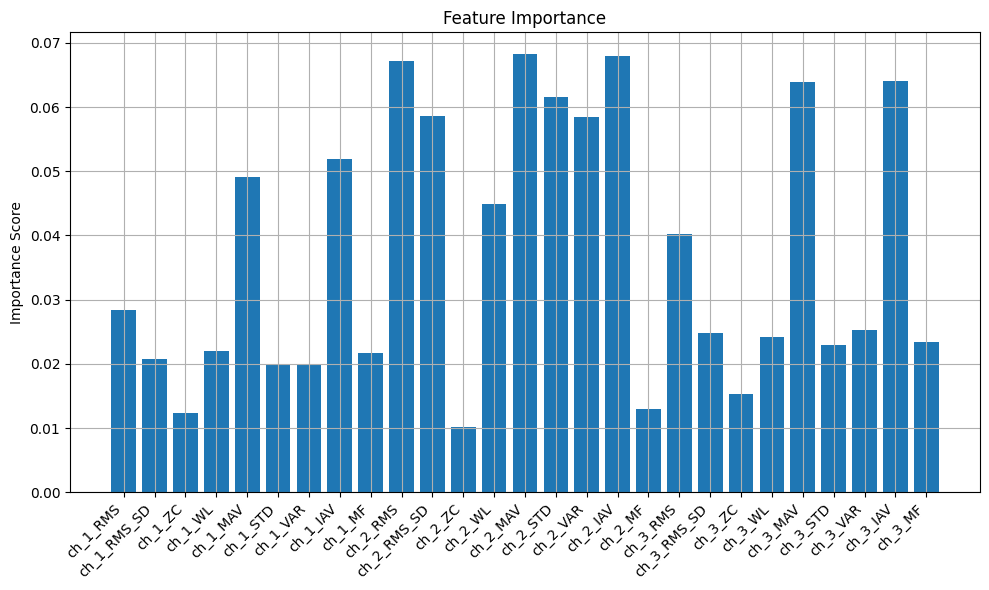

In [31]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
import seaborn as sns
import matplotlib.pyplot as plt
import joblib
import pandas as pd

# 1. Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# 2. Optional: scale features
if USE_SCALING:
    scaler_RF = StandardScaler()
    X_train_array = scaler_RF.fit_transform(X_train)
    X_test_array = scaler_RF.transform(X_test)
    X_train_df = pd.DataFrame(X_train_array, columns=X.columns)
    X_test_df = pd.DataFrame(X_test_array, columns=X.columns)
else:
    X_train_df = X_train.copy()
    X_test_df = X_test.copy()

# 3. Optional: feature selection
if USE_FEATURESELECTION:
    selector_RF = SelectKBest(score_func=f_classif, k=k)
    X_train_array = selector_RF.fit_transform(X_train_df, y_train)
    X_test_array = selector_RF.transform(X_test_df)

    selected_features = X_train_df.columns[selector_RF.get_support()]
    X_train_final = pd.DataFrame(X_train_array, columns=selected_features)
    X_test_final = pd.DataFrame(X_test_array, columns=selected_features)
else:
    X_train_final = X_train_df
    X_test_final = X_test_df
    selected_features = X.columns  # for plotting

# 4. Train classifier
clf_RF = RandomForestClassifier(n_estimators=500, random_state=42)
clf_RF.fit(X_train_final, y_train)
y_pred = clf_RF.predict(X_test_final)

# 5. Evaluate
acc = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred, labels=['l', 'lf', 'f', 'rf', 'r', 's', 'n'])

print(f"Random Forest Test Accuracy: {acc:.3f}")

# 6. Plot confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['l', 'lf', 'f', 'rf', 'r', 's', 'n'],
            yticklabels=['l', 'lf', 'f', 'rf', 'r', 's', 'n'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# 7. Plot feature importance
importances = clf_RF.feature_importances_

plt.figure(figsize=(10, 6))
plt.bar(selected_features, importances)
plt.title("Feature Importance")
plt.ylabel("Importance Score")
plt.xticks(rotation=45, ha='right')
plt.grid(True)
plt.tight_layout()
plt.show()

# 8. Save model (and optionally scaler and selector)
joblib.dump(clf_RF, "6_classes_rf_17_09.pkl")
if USE_SCALING:
    joblib.dump(scaler_RF, "6_classes_scaler_rf_17_09.pkl")
if USE_FEATURESELECTION:
    joblib.dump(selector_RF, "6_classes_selector_rf_17_09.pkl")


## Cross Validation

In [32]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer, accuracy_score, confusion_matrix
import joblib
import numpy as np
import pandas as pd

# ----------------------------- CONFIG -----------------------------
n_splits = 5  # Number of CV folds
random_state = 42
labels_order = ['l', 'lf', 'f', 'rf', 'r', 's', 'n']

# ------------------------ CLASSIFIER PIPELINE ------------------------
steps = []
if USE_SCALING == 1:
    steps.append(('scaler', StandardScaler()))
if USE_FEATURESELECTION == 1:
    steps.append(('feature_selection', SelectKBest(score_func=f_classif, k=k)))
steps.append(('classifier', RandomForestClassifier(n_estimators=500, random_state=random_state)))

pipeline = Pipeline(steps)

# -------------------------- CROSS-VALIDATION --------------------------
cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)

scoring = {
    'accuracy': 'accuracy'
}

cv_results = cross_validate(
    pipeline, X, y,
    cv=cv,
    scoring=scoring,
    return_estimator=True,
    return_train_score=True
)

# -------------------------- RESULTS SUMMARY --------------------------
print(f"\nCross-Validation Accuracy Scores: {cv_results['test_accuracy']}")
print(f"Mean Accuracy: {np.mean(cv_results['test_accuracy']):.3f}")
print(f"Std Deviation: {np.std(cv_results['test_accuracy']):.3f}")




Cross-Validation Accuracy Scores: [0.88095238 0.83333333 0.89285714 0.92857143 0.79761905]
Mean Accuracy: 0.867
Std Deviation: 0.046


## PCA 

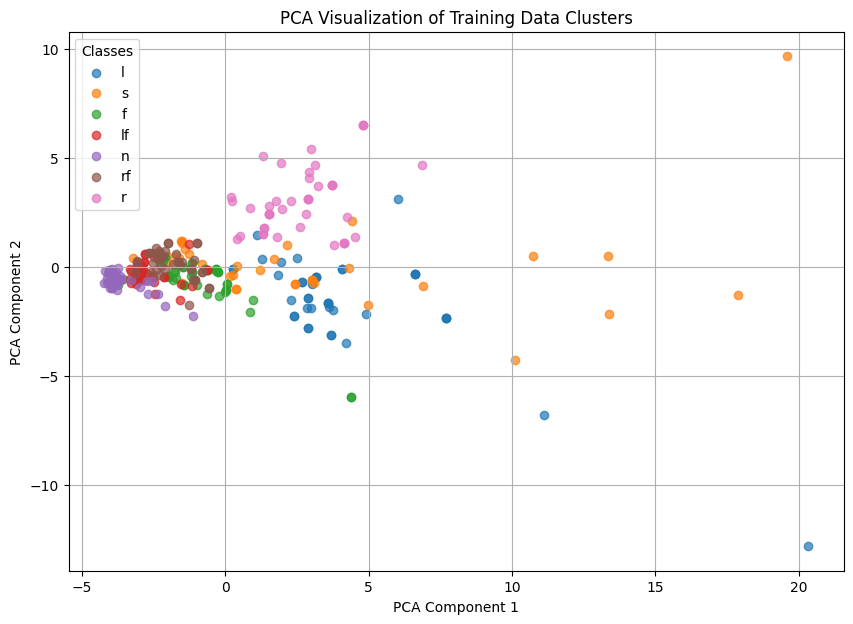

In [33]:
from sklearn.decomposition import PCA

# 2.5 PCA for visualization (2D)
pca = PCA(n_components=2)

if USE_SCALING == 1:
    X_train_pca = pca.fit_transform(X_train_scaled)
else:
    X_train_pca = pca.fit_transform(X_train)

# Plot
plt.figure(figsize=(10, 7))
for label in y_train.unique():
    idx = y_train == label
    plt.scatter(X_train_pca[idx, 0], X_train_pca[idx, 1], label=label, alpha=0.7)

plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('PCA Visualization of Training Data Clusters')
plt.legend(title='Classes')
plt.grid(True)
plt.show()


## SVM

SVM Test Accuracy: 0.786


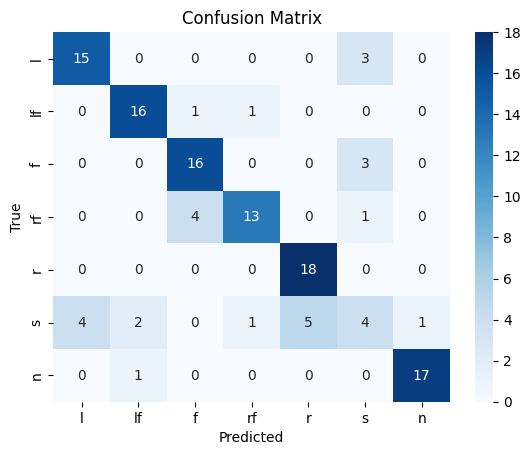

In [16]:
# ----------------------------- SUPPORT VECTOR MACHINE

from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
import joblib
import pandas as pd

# 1. Split data 
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# 2. Scale features
scaler = StandardScaler()
X_train_scaled_array = scaler.fit_transform(X_train)
X_test_scaled_array = scaler.transform(X_test)

# Wrap back into DataFrames with feature names
X_train_scaled = pd.DataFrame(X_train_scaled_array, columns=X.columns)
X_test_scaled = pd.DataFrame(X_test_scaled_array, columns=X.columns)

# 3. Train 
clf_SVM = SVC(kernel='linear', C=1.0, gamma='scale', class_weight='balanced')
clf_SVM.fit(X_train_scaled, y_train)

# 4. Predict
y_pred = clf_SVM.predict(X_test_scaled)

# 5. Evaluate
acc = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred, labels=['l', 'lf', 'f', 'rf', 'r', 's', 'n'])

print(f"SVM Test Accuracy: {acc:.3f}")

# 6. Plot confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['l', 'lf', 'f', 'rf', 'r', 's', 'n'],
            yticklabels=['l', 'lf', 'f', 'rf', 'r', 's', 'n'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# 7. Save model and scaler
#joblib.dump(clf_SVM, "7_classes_svm.pkl")
#joblib.dump(scaler, "scaler_svm.pkl")


# Additional Test

## Random Forest Tree

Random Forest Test Accuracy: 0.556


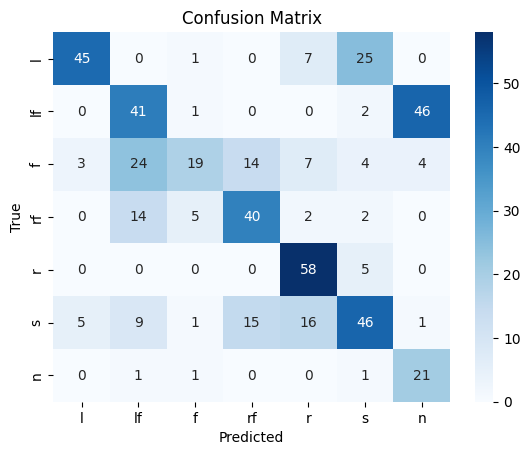

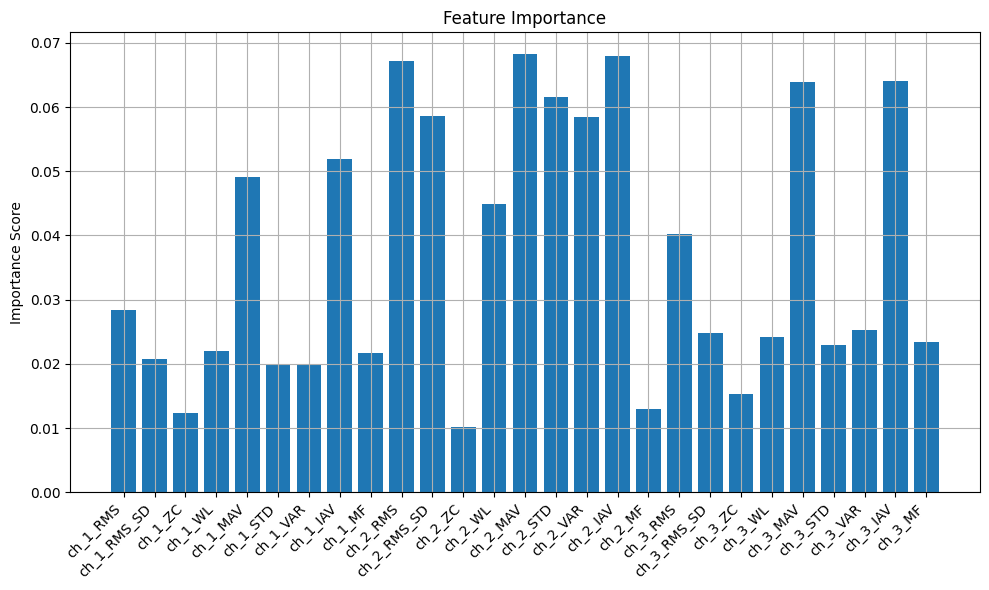

In [17]:
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

if USE_SCALING == 1:
    Xt_scaled_array = scaler_RF.transform(Xt)
    Xt_scaled = pd.DataFrame(Xt_scaled_array, columns=Xt.columns)
    y_pred = clf_RF.predict(Xt_scaled)
else:
    y_pred = clf_RF.predict(Xt)
    
# Evaluate accuracy
acc = accuracy_score(yt, y_pred)
print(f"Random Forest Test Accuracy: {acc:.3f}")

# Compute confusion matrix
labels_order = ['l', 'lf', 'f', 'rf', 'r', 's', 'n']
cm = confusion_matrix(yt, y_pred, labels=labels_order)

# Plot confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels_order,
            yticklabels=labels_order)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# Plot feature importance
importances = clf_RF.feature_importances_
feature_names = Xt.columns if hasattr(Xt, 'columns') else [f'feat{i}' for i in range(Xt.shape[1])]

plt.figure(figsize=(10,6))
plt.bar(feature_names, importances)
plt.title("Feature Importance")
plt.ylabel("Importance Score")
plt.xticks(rotation=45, ha='right')
plt.grid(True)
plt.tight_layout()
plt.show()


## Random Forest Tree with Feature Selection

Random Forest Test Accuracy: 0.556


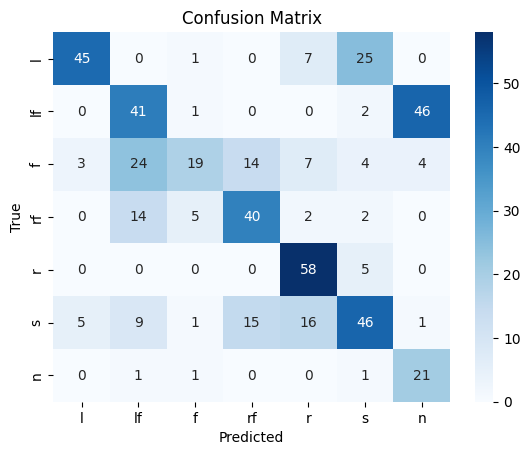

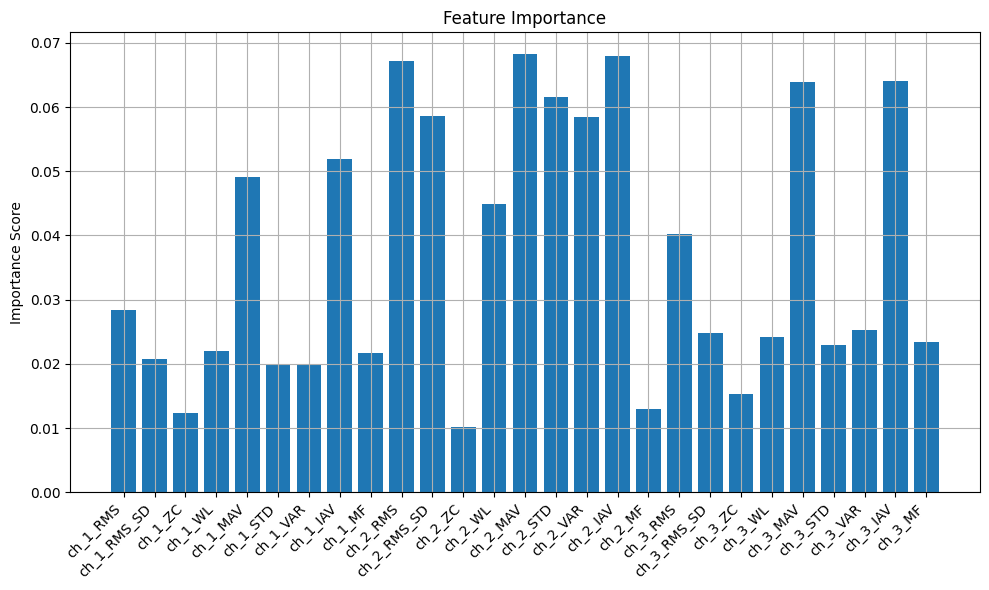

In [18]:

# Apply scaling if used during training
if USE_SCALING == 1:
    Xt_scaled_array = scaler_RF.transform(Xt)
    Xt_scaled = pd.DataFrame(Xt_scaled_array, columns=Xt.columns)
else:
    Xt_scaled = Xt.copy()

# Apply feature selection if used during training
if USE_FEATURESELECTION == 1:
    Xt_selected_array = selector_RF.transform(Xt_scaled)
    selected_features = Xt_scaled.columns[selector_RF.get_support()]
    Xt_selected = pd.DataFrame(Xt_selected_array, columns=selected_features)
else:
    Xt_selected = Xt_scaled

# Make prediction
y_pred = clf_RF.predict(Xt_selected)

# Evaluate accuracy
acc = accuracy_score(yt, y_pred)
print(f"Random Forest Test Accuracy: {acc:.3f}")

# Compute confusion matrix
labels_order = ['l', 'lf', 'f', 'rf', 'r', 's', 'n']
cm = confusion_matrix(yt, y_pred, labels=labels_order)

# Plot confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels_order,
            yticklabels=labels_order)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# Plot feature importance
importances = clf_RF.feature_importances_
feature_names = Xt_selected.columns

plt.figure(figsize=(10, 6))
plt.bar(feature_names, importances)
plt.title("Feature Importance")
plt.ylabel("Importance Score")
plt.xticks(rotation=45, ha='right')
plt.grid(True)
plt.tight_layout()
plt.show()
